In [1]:
import numpy as np
import pandas as pd 
import os 
import json
from pandas.io.json import json_normalize
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

Import Sagemaker modules
* sagemaker_session: The SageMaker session we'll use for training models.
* bucket: The name of the default S3 bucket that we'll use for data storage.
* role: The IAM role that defines our data and model permissions.

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

session = sagemaker.Session()
role = get_execution_role()

# S3 bucket name
bucket = session.default_bucket()

In [3]:
bucket

'sagemaker-us-east-1-260679286230'

# Load and Explore Data 

The dataset is downloaded from Kaggle

In [1]:
! cat data/train_clean.csv | wc -l

903654


In [3]:
train = pd.read_csv('data/train_clean.csv')
# test = pd.read_csv('data/test_clean.csv')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# create non-zero revenue df
train_pos = train.loc[pd.notnull(train['totals.transactionRevenue'])]

In [4]:
train.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,...,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,...,1.0,1.0,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,...,NaN,1.0,NaN,NaN,(not set),True,(not provided),organic,NaN,google


In [5]:
train.dtypes

channelGrouping                object
date                            int64
fullVisitorId                  object
visitId                         int64
visitNumber                     int64
visitStartTime                  int64
device.browser                 object
device.deviceCategory          object
device.isMobile                  bool
device.operatingSystem         object
geoNetwork.city                object
geoNetwork.continent           object
geoNetwork.country             object
geoNetwork.metro               object
geoNetwork.networkDomain       object
geoNetwork.region              object
geoNetwork.subContinent        object
totals.bounces                float64
totals.hits                     int64
totals.newVisits              float64
totals.pageviews              float64
totals.transactionRevenue     float64
trafficSource.adContent        object
trafficSource.campaign         object
trafficSource.isTrueDirect     object
trafficSource.keyword          object
trafficSourc

In [8]:
train['geoNetwork.subContinent'].unique()

array(['Western Asia', 'Australasia', 'Southern Europe', 'Southeast Asia',
       'Northern Europe', 'Southern Asia', 'Western Europe',
       'South America', 'Eastern Asia', 'Eastern Europe',
       'Northern America', 'Western Africa', 'Central America',
       'Eastern Africa', '(not set)', 'Caribbean', 'Southern Africa',
       'Northern Africa', 'Central Asia', 'Middle Africa', 'Melanesia',
       'Micronesian Region', 'Polynesia'], dtype=object)

### 1. Outcome: natural log of sum of all transactions

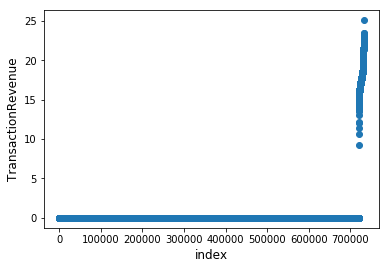

In [5]:
gdf = train.groupby('fullVisitorId').agg({'totals.transactionRevenue':'sum'}).reset_index()

plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize = 12)
plt.ylabel('TransactionRevenue', fontsize = 12)
plt.show()

As shown in the graph, a small proportion of the customers produce most of the revenue. These are the most valuable customers which we need to identity their identities, behavior patterns and act accordingly

In [6]:
print('percent of non-zero transactions: {}'.format(
    str(pd.notnull(train["totals.transactionRevenue"]).sum()/train.shape[0])))
print('percent of customers with non-zero revenues: {}'.format(
    str((gdf["totals.transactionRevenue"]>0).sum()/gdf.shape[0])))

percent of non-zero transactions: 0.0127427231470487
percent of customers with non-zero revenues: 0.013976902495279737


Of all the customers visit the google store from 2016-08-01 to 2017-08-01, only 1.4% of the vistors are actually revenue generated customers. 

### 2. Device Information

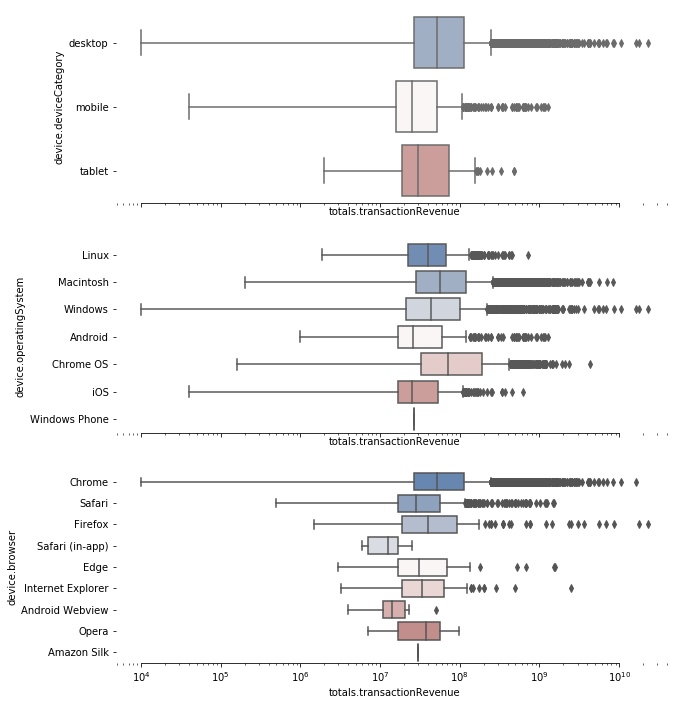

In [91]:
f, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10,12), sharex = True)

sns.boxplot(x = "totals.transactionRevenue", y = "device.deviceCategory", data = train, palette="vlag", ax = ax[0])
ax[0].set_xscale("log")
sns.boxplot(x = "totals.transactionRevenue", y = "device.operatingSystem", 
            data = train.loc[train["totals.transactionRevenue"] > 0], palette="vlag", ax = ax[1])
ax[1].set_xscale("log")

sns.boxplot(x = "totals.transactionRevenue", y = "device.browser", 
            data = train.loc[train["totals.transactionRevenue"] > 0], palette="vlag", ax = ax[2])
ax[2].set_xscale("log")
sns.despine(trim=True, left=True)

### 3. Country Data

In [13]:
country_order = train_pos.groupby('geoNetwork.country')['totals.transactionRevenue'].median().sort_values(ascending = False).index.values[:40]

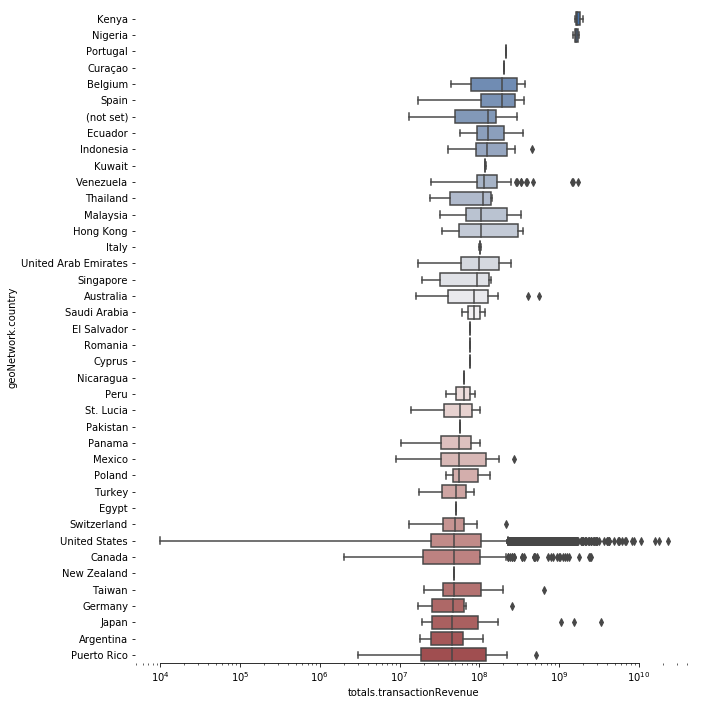

In [14]:
f, ax = plt.subplots(figsize = (10,12))
ax.set_xscale("log")
sns.boxplot(x = "totals.transactionRevenue", y = "geoNetwork.country", data = train_pos, palette="vlag", order = country_order)
sns.despine(trim=True, left=True)

### 4. Chanel Grouping

In [18]:
chanel_order = train_pos.groupby('channelGrouping')['totals.transactionRevenue'].median().sort_values(ascending = False).index

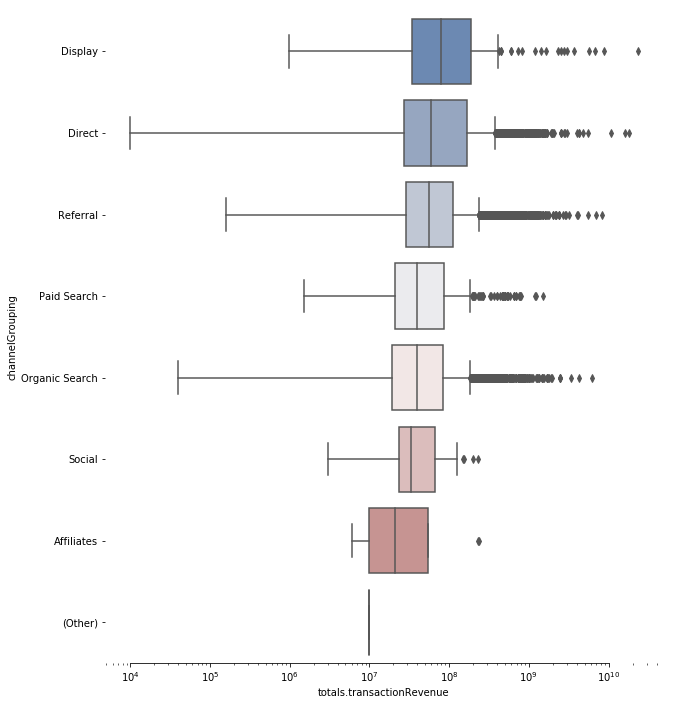

In [19]:
f, ax = plt.subplots(figsize = (10,12))
ax.set_xscale("log")
sns.boxplot(x = "totals.transactionRevenue", y = "channelGrouping", data = train_pos, palette="vlag", order = chanel_order)
sns.despine(trim=True, left=True)

### 5. PageViews Distribution

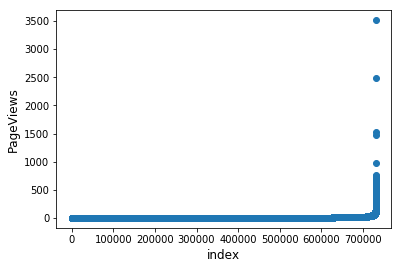

In [93]:
df_pv = train.groupby('fullVisitorId').agg({'totals.pageviews':'sum'}).reset_index()

plt.scatter(range(df_pv.shape[0]), np.sort(df_pv["totals.pageviews"].values))
plt.xlabel('index', fontsize = 12)
plt.ylabel('PageViews', fontsize = 12)
plt.show()

In [59]:
train['totals.pageviews'].describe()

count    903553.000000
mean          3.849764
std           7.025274
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         469.000000
Name: totals.pageviews, dtype: float64

Page views show a similar pattern as our outcome-- the transactions data. It will be a good indirect indicator for our outcome data.

# Feature Engineering

In this part, I created customer segmentations using RFM.
**RFM** stands for Recency- Frequency - Monetary Value.

The segments include:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generate very low-zero-maybe negative revenue.
* Mid Value: Customers who are using the Google platform farily frequent and generate moderate revenue.
* High Value: High revenue, frequency and low inactivity.

### Recency
* to find out most recent purchase date of each customer by 2017-08-01

In [4]:
train_pp = train.loc[pd.notnull(train['totals.pageviews'])]

In [5]:
# create a generic user dataframe to keep customerid and new segmentation scores 
tx_user = pd.DataFrame(train_pp.fullVisitorId.unique())
tx_user.columns = ['fullVisitorId']

In [6]:
# get the max purchase date for each customers
tx_max_purchase = train_pp.groupby('fullVisitorId')['date'].max().reset_index()

In [7]:
tx_max_purchase['date'] = pd.to_datetime(tx_max_purchase['date'],format = "%Y%m%d")
tx_max_purchase['recency'] = (tx_max_purchase['date'].max() - tx_max_purchase['date']).dt.days

In [8]:
tx_user = pd.merge(tx_user, tx_max_purchase[['fullVisitorId', 'recency']], on = 'fullVisitorId')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


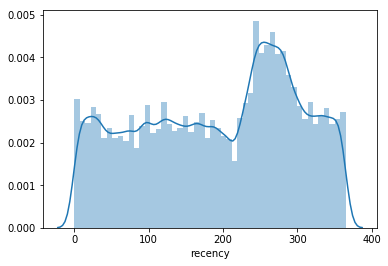

In [11]:
sns.distplot(tx_user['recency'])

In [12]:
tx_user.recency.describe()

count    731407.000000
mean        192.778081
std         104.437834
min           0.000000
25%         103.000000
50%         207.000000
75%         279.000000
max         365.000000
Name: recency, dtype: float64

From the graph and stats above, we see that the average is 192 day recency, median is 207. The graph shows a spike in purchases, which could be caused by the holiday season.

In [9]:
def find_num_clusters(feature):
    sse = {}
    
    df = tx_user[[feature]]
    for k in range(1,10):
        kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df)
    #     tx_recency['cluster'] = kmeans.labels_
        sse[k] = kmeans.inertia_
    
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()

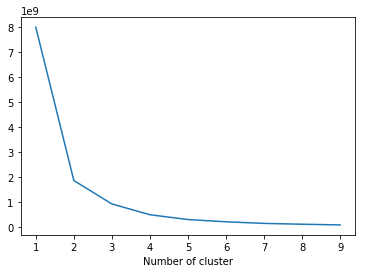

In [14]:
find_num_clusters('recency')

Based on the graph above, 3 or 4 clusters are the optimal ones. I will select 4 cluster here

In [10]:
# build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['recency']])
tx_user['recency_cluster'] = kmeans.predict(tx_user[['recency']])

## Save model for test as well
filename = "feature_models/kmeans_recency.sav"
pickle.dump(kmeans, open(filename, 'wb')) #write bytes

In [10]:
tx_user.groupby('recency_cluster').agg({'recency':['min','max','mean']})

recency                 
                    min  max        mean
recency_cluster                         
0                     0   95   45.677548
1                   198  287  249.185158
2                    96  197  145.761212
3                   288  365  324.950815

In [17]:
kmeans.inertia_

503684962.3435046

In [11]:
# clean up
tx_max_purchase = None

### Frequency 
* to find total number orders for each customer

In [12]:
tx_freq = train_pp.groupby('fullVisitorId').agg({'visitId':'count'}).reset_index()
tx_freq.rename(columns={'visitId': 'freq'},inplace= True)
tx_user = pd.merge(tx_user, tx_freq[['fullVisitorId', 'freq']], on = 'fullVisitorId')

In [20]:
tx_user.head()

,fullVisitorId,recency,recency_cluster,freq
0,1131660440785968503,333,2,1
1,377306020877927890,333,2,1
2,3895546263509774583,333,2,1
3,4763447161404445595,333,2,1
4,27294437909732085,333,2,2


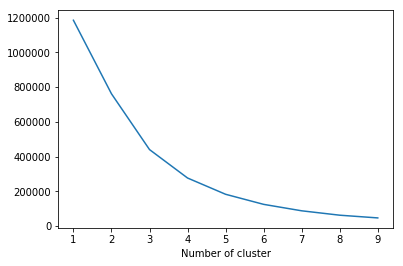

In [21]:
find_num_clusters('freq')

Based on the graph above, 4 or 5 clusters are the optimal ones. I will select 5 cluster here

In [13]:
# build 5 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(tx_user[['freq']])
tx_user['freq_cluster'] = kmeans.predict(tx_user[['freq']])

## Save model for test as well
filename = "feature_models/kmeans_freq.sav"
pickle.dump(kmeans, open(filename, 'wb')) #write bytes

In [23]:
tx_user.groupby('freq_cluster').agg({'freq':['min','max','mean']})

freq                 
              min  max        mean
freq_cluster                      
0               1    1    1.000000
1              19   77   29.163205
2               5   18    7.000239
3              83  252  128.200000
4               2    4    2.364575

In [14]:
#clean up
tx_freq = None

### Monetary

In [15]:
tx_pv = train_pp.groupby('fullVisitorId').agg({'totals.pageviews':'sum'}).reset_index()
tx_pv.rename(columns={'totals.pageviews': 'pageviews'},inplace= True)
tx_user = pd.merge(tx_user, tx_pv[['fullVisitorId', 'pageviews']], on = 'fullVisitorId')

In [26]:
tx_user.pageviews.describe()

count    731407.000000
mean          4.755855
std          13.004957
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        3513.000000
Name: pageviews, dtype: float64

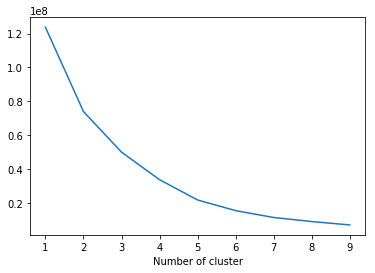

In [27]:
find_num_clusters('pageviews')

In [16]:
# build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['pageviews']])
tx_user['pv_cluster'] = kmeans.predict(tx_user[['pageviews']])

## Save model for test as well
filename = "feature_models/kmeans_pv.sav"
pickle.dump(kmeans, open(filename, 'wb')) #write bytes

In [17]:
tx_user.groupby('pv_cluster').agg({'pageviews':['min','max','mean']})

pageviews                     
                 min     max         mean
pv_cluster                               
0                1.0    19.0     3.035733
1              118.0   969.0   197.508368
2               20.0   117.0    36.711200
3             1477.0  3513.0  2251.000000

In [17]:
tx_pv = None

### Country
-  In the Load and Explore Data step, we can see there are a lot of country values in this dataset. To save the memory for model training, I will group countries with similar transaction revenues into one segment.

In [18]:
df_country = train.groupby('geoNetwork.country')['totals.pageviews'].agg(['max','min','median','count','mean','sum','std']).reset_index()
df_country.columns = ['country', 'max_val', 'min_val', 'median_val', 'cnt','mean_val','sum_val','std']

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
for col in df_country.columns[1:]:
    scaler = MinMaxScaler()
    df_country['scl_'+col] = scaler.fit_transform(df_country[[col]])

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [20]:
df_country.fillna(0,inplace = True)

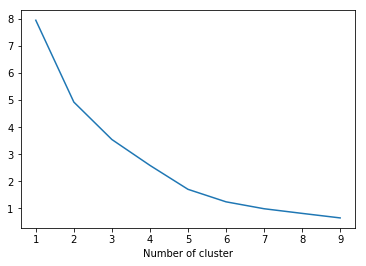

In [21]:
sse = {}
    
for k in range(1,10):
    kmeans = KMeans(n_clusters = k, max_iter = 1000).fit(df_country.loc[:,['scl_std','scl_median_val','scl_sum_val','scl_mean_val']])
#     tx_recency['cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

From the above graph, we can tell that 5/6 would be the optimal clusters. I will choose 6 here

In [22]:
kmeans = KMeans(n_clusters= 6)
kmeans.fit(df_country.loc[:,['scl_std','scl_median_val','scl_sum_val','scl_mean_val']])
df_country['country_cluster'] = kmeans.predict(df_country.loc[:,['scl_std','scl_median_val','scl_sum_val','scl_mean_val']])

In [23]:
## Save model for test as well
filename = "feature_models/kmeans_country.sav"
pickle.dump(kmeans, open(filename, 'wb')) #write bytes

### Apply Feature Engineering to Test Dataset

In [97]:
# create a generic test user dataframe
tst_pp = test.loc[pd.notnull(test['totals.pageviews'])]
tst_tx_user = pd.DataFrame(tst_pp['fullVisitorId'].unique())
tst_tx_user.columns = ['fullVisitorId']

In [25]:
# create recency
tst_tx_max_purchase = tst_pp.groupby('fullVisitorId')['date'].max().reset_index()
tst_tx_max_purchase.columns = ['fullVisitorId', 'max_date']
tst_tx_max_purchase['max_date'] = pd.to_datetime(tst_tx_max_purchase['max_date'], format = '%Y%m%d')

tst_tx_max_purchase['recency'] = (tst_tx_max_purchase['max_date'].max() - tst_tx_max_purchase['max_date']).dt.days
tst_tx_user = pd.merge(tst_tx_user, tst_tx_max_purchase[['fullVisitorId', 'recency']], on = 'fullVisitorId')

NameError: name 'tst_pp' is not defined

In [27]:
# create frequency
tst_tx_freq = test.groupby('fullVisitorId')['visitId'].count().reset_index()
tst_tx_freq.columns = ['fullVisitorId', 'freq']

tst_tx_user = pd.merge(tst_tx_user, tst_tx_freq, on = 'fullVisitorId')

In [28]:
# create pageviews
tst_pv = tst_pp.groupby('fullVisitorId')['totals.pageviews'].sum().reset_index()

tst_tx_user = pd.merge(tst_tx_user, tst_pv, on = 'fullVisitorId')
tst_tx_user.rename(columns={'totals.pageviews': 'pv'}, inplace= True)

In [29]:
mod_name = ['recency', 'freq', 'pv']

for f in mod_name:
    mod1 = pickle.load(open('feature_models/kmeans_{}.sav'.format(f), 'rb'))
    tst_tx_user[f + "_cluster"] = mod1.predict(tst_tx_user[[f]])

In [30]:
# create country cluster
tst_country = tst_pp.groupby('geoNetwork.country')['totals.pageviews'].agg(['max','min','median','count','mean','sum','std']).reset_index()
tst_country.columns = ['geoNetwork.country', 'max_val', 'min_val', 'median_val', 'cnt','mean_val','sum_val','std']

for col in tst_country.columns[1:]:
    scaler = MinMaxScaler()
    tst_country['scl_'+col] = scaler.fit_transform(tst_country[[col]])

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [31]:
tst_country.fillna(0, inplace = True)
mod1 = pickle.load(open('feature_models/kmeans_country.sav','rb'))
tst_country['country_cluster'] = mod1.predict(tst_country[['scl_std','scl_median_val','scl_sum_val','scl_mean_val']])

### Join Features back to Train and Test

In [130]:
train_out.head()

,key_0,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,recency_cluster,freq_cluster,pv_cluster,country,country_cluster
0,Turkey,Organic Search,20160902,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,...,NaN,(not provided),organic,NaN,google,3,0,0,Turkey,1
1,Turkey,Organic Search,20160902,357659889600827884,1472839882,1,1472839882,Safari,mobile,True,...,NaN,(not provided),organic,NaN,google,3,0,0,Turkey,1
2,Turkey,Organic Search,20160902,9675839814855309060,1472811887,1,1472811887,Chrome,desktop,False,...,NaN,(not provided),organic,NaN,google,3,0,0,Turkey,1
3,Turkey,Organic Search,20160902,9987056085213279488,1472842263,1,1472842263,Chrome,desktop,False,...,NaN,(not provided),organic,NaN,google,3,0,0,Turkey,1
4,Turkey,Organic Search,20160902,2936426984187397286,1472833893,1,1472833893,Chrome,desktop,False,...,NaN,(not provided),organic,NaN,google,3,0,0,Turkey,1


In [24]:
feature_cluster = ['recency_cluster', 'freq_cluster', 'pv_cluster']
train_in = pd.merge(train, tx_user[['fullVisitorId'] + feature_cluster], on ='fullVisitorId')
train_in = train_in.merge(df_country[['country', 'country_cluster']], left_on = train_in['geoNetwork.country'], right_on = df_country['country'])

# test_out = pd.merge(test, tst_tx_user[['fullVisitorId'] + feature_cluster], on ='fullVisitorId')
# test_out = test_out.merge(tst_country[['geoNetwork.country', 'country_cluster']], on = 'geoNetwork.country')

In [25]:
def fill_null_cluster(df, feature_cluster):
    for f in feature_cluster:
        df.loc[pd.isnull(df[f]),[f]] = -1
    return df

In [26]:
train_in = fill_null_cluster(train_in, feature_cluster)
# test_out = fill_null_cluster(test_out, feature_cluster)

In [27]:
train_in.shape

(903639, 35)

## Clean Up the Memory

In [29]:
df_lst =[x for x in [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]]
df_lst

['df_country', 'test', 'train', 'train_out', 'train_pp', 'tx_user']

In [30]:
# clean up
df_country = None
test= None
train= None
train_pos= None
train_pp= None
tst_country= None
tst_pp= None
tst_pv= None
tst_tx_freq= None
tst_tx_max_purchase= None
tst_tx_user= None
tx_user= None

# Upload Data to S3

In [27]:
agg_lv = ['fullVisitorId']
features_lst = ['country_cluster', 
                'channelGrouping', 
                'device.deviceCategory', 'device.operatingSystem', 
                'recency_cluster', 'freq_cluster', 'pv_cluster',
                'totals.hits']

In [158]:
train_agg.head()

,country_cluster,recency_cluster,freq_cluster,pv_cluster,totals.hits,totals.transactionRevenue
fullVisitorId,,,,,,
4823595352351,5.0,1,0,0,1,0.0
5103959234087,4.0,3,0,0,10,0.0
10278554503158,5.0,1,0,0,11,0.0
20424342248747,5.0,1,0,0,17,0.0
26722803385797,5.0,0,0,0,3,0.0


In [28]:
from scipy.stats import mode
train_agg = train_in.groupby('fullVisitorId').agg(
    {'recency_cluster': 'mean',
    'freq_cluster': 'mean',
    'pv_cluster': 'mean',
    'totals.hits': 'sum',
    'totals.transactionRevenue': 'sum'})
series_channel = train_in.groupby('fullVisitorId')['channelGrouping'].agg(lambda x: x.mode())
series_device = train_in.groupby('fullVisitorId')['device.deviceCategory'].agg(lambda x: x.mode())
series_os = train_in.groupby('fullVisitorId')['device.operatingSystem'].agg(lambda x: x.mode())
series_country = train_in.groupby('fullVisitorId')['country_cluster'].agg(lambda x: x.mode())

In [29]:
train_out = pd.concat([train_agg, series_channel, series_device, series_os, series_country], axis = 1)

In [30]:
train_feature = train_out[features_lst]
for col in [c for c in features_lst if c != 'totals.hits']:
    train_feature[col] = train_feature[col].astype('str')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [31]:
train_feature = pd.get_dummies(train_feature, drop_first = True)

In [32]:
# log the outcome
train_out['log_rev'] = np.log1p(train_out['totals.transactionRevenue'])

In [33]:
train_out.loc[pd.isnull(train_out['totals.transactionRevenue'])]

,recency_cluster,freq_cluster,pv_cluster,totals.hits,totals.transactionRevenue,channelGrouping,device.deviceCategory,device.operatingSystem,country_cluster,log_rev
fullVisitorId,,,,,,,,,,


In [35]:
train_x, dev_x, train_y, dev_y = train_test_split(train_feature, train_out['log_rev'], test_size = 0.2, random_state = 41 )

In [149]:
train_y[:5]

fullVisitorId
4307970802372098428    0.0
976508791238108174     0.0
5619296296197774766    0.0
4594970192458431208    0.0
808396189624475187     0.0
Name: totals.transactionRevenue, dtype: float64

In [64]:
# clean up
train_out = None
train_feature = None
test_out = None

In [36]:
# should be the name of directory you created to save your features data
data_dir = 'data'

# set prefix, a descriptive name for a directory  
prefix = 'capstone'

# save train data to the local folder
train_data = pd.concat([train_y, train_x], axis = 1)
train_data.loc[pd.isnull(train_data['log_rev']),'log_rev'] = 0
train_data.to_csv(os.path.join(data_dir, 'train_data.csv'), header = False, index = False)

test_data = pd.concat([dev_y, dev_x], axis =1)
test_data.to_csv(os.path.join(data_dir, 'test_data.csv'), header = False, index = False)

In [37]:
# should be the name of directory you created to save your features data
data_dir = 'data'

# set prefix, a descriptive name for a directory  
prefix = 'google_analytics'

# upload all data to S3
train_location = session.upload_data(os.path.join(data_dir, 'train_data.csv'), key_prefix = prefix)
test_location = session.upload_data(os.path.join(data_dir, 'test_data.csv'), key_prefix = prefix)

In [55]:
#clean up
train_x = None
test_x = None

# Modeling

In [49]:
!pygmentize source/train.py

from __future__ import print_function

import argparse
import os
import pandas as pd

from sklearn.externals import joblib

## TODO: Import any additional libraries you need to define a model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

# Provided model load function
def model_fn(model_dir):
    """Load model from the model_dir. This is the same model that is saved
    in the main if statement.
    """
    print("Loading model.")
    
    # load using joblib
    model = joblib.load(os.path.join(model_dir, "model.joblib"))
    print("Done loading model.")
    
    return model


## TODO: Complete the main code
if __name__ == '__main__':
    
    # All of the model parameters and training parameters are sent as arguments
    # when this script is executed, during a training job
    
    # Here we set up an argument parser to easily access the parameters
    parser = argparse.ArgumentParser()

    # SageMaker parameters, like the d

## Base Model

### Create an Estimator

In [38]:
from sagemaker.sklearn.estimator import SKLearn

output_path = 's3://{}/{}'.format(bucket, prefix)

In [39]:
estimator = SKLearn(entry_point = 'train.py',
                    source_dir = 'source',
                    role = role,
                    framework_version = '0.20.0',
                    train_instance_count = 1,
                    train_instance_type = 'ml.c4.xlarge',
                    output_path = output_path,
                    sagemaker_session = session)

In [40]:
estimator.fit({'train': train_location})

2020-06-16 17:44:06 Starting - Starting the training job...
2020-06-16 17:44:09 Starting - Launching requested ML instances.........
2020-06-16 17:45:52 Starting - Preparing the instances for training......
2020-06-16 17:46:41 Downloading - Downloading input data...
2020-06-16 17:47:35 Training - Training image download completed. Training in progress..2020-06-16 17:47:37,130 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-06-16 17:47:37,133 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-16 17:47:37,143 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-06-16 17:47:44,567 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-06-16 17:47:44,567 sagemaker-containers INFO     Generating setup.cfg
2020-06-16 17:47:44,568 sagemaker-containers INFO     Generating MANIFEST.in
2020-06-16 17:47:44,568 sagemaker-containers INFO     Installing

### Deploy a Trained Model - Baseline

In [ ]:
%%time

predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')

------

### Evaluate the Model

In [ ]:
data_dir

In [44]:
test_data = pd.read_csv(os.path.join(data_dir, "test_data.csv"), header = None, names = None)

test_y = test_data.iloc[:,0]
test_y.fillna(0, inplace = True)

In [28]:
test_y[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0, dtype: float64

In [45]:
test_y.fillna(0, inplace = True)

In [112]:
test_data.shape

(180728, 45)

In [46]:
test_y_preds = np.array([])
for i in range(0, test_data.shape[0],1000):
    test_x = test_data.iloc[i:i+1000,1:]
    preds = predictor.predict(test_x)
#     preds = np.where(preds<0, 0, preds)
    test_y_preds = np.concatenate([test_y_preds, preds])

In [48]:
# Second: calculate the test accuracy
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test_y, test_y_preds)

print(np.sqrt(rmse))

1.8326098590428952


In [50]:
predictor.delete_endpoint()

## Production Model

In [51]:
estimator = SKLearn(entry_point = 'train-rf.py',
                    source_dir = 'source',
                    role = role,
                    framework_version = '0.20.0',
                    train_instance_count = 1,
                    train_instance_type = 'ml.c4.xlarge',
                    output_path = output_path,
                    sagemaker_session = session)

In [52]:
estimator.fit({'train': train_location})

2020-06-16 20:06:59 Starting - Starting the training job...
2020-06-16 20:07:01 Starting - Launching requested ML instances......
2020-06-16 20:08:20 Starting - Preparing the instances for training......
2020-06-16 20:09:14 Downloading - Downloading input data...
2020-06-16 20:09:43 Training - Downloading the training image..2020-06-16 20:10:04,263 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2020-06-16 20:10:04,266 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-06-16 20:10:04,276 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-06-16 20:10:11,793 sagemaker-containers INFO     Module train-rf does not provide a setup.py. 
Generating setup.py
2020-06-16 20:10:11,793 sagemaker-containers INFO     Generating setup.cfg
2020-06-16 20:10:11,793 sagemaker-containers INFO     Generating MANIFEST.in
2020-06-16 20:10:11,793 sagemaker-containers INFO     Installing module with the followin

In [53]:
%%time

predictor = estimator.deploy(initial_instance_count = 1, instance_type = 'ml.t2.medium')

-----------------!CPU times: user 289 ms, sys: 24.8 ms, total: 314 ms
Wall time: 8min 32s


In [54]:
test_y_preds = np.array([])
for i in range(0, test_data.shape[0],500):
    test_x = test_data.iloc[i:i+500,1:]
    preds = predictor.predict(test_x)
#     preds = np.where(preds<0, 0, preds)
    test_y_preds = np.concatenate([test_y_preds, preds])

In [55]:
rmse = mean_squared_error(test_y, test_y_preds)

print(np.sqrt(rmse))

1.7528440766745172


In [56]:
predictor.delete_endpoint()